# Imports and Setup

In [1]:
import sys
import json
sys.path.append('../')

from utils import set_api_key
from models.sda import SelfDiscovery
from models.rag import SelfRAG

from IPython.display import Image, display

/Users/radoslawizak/Desktop/MSc Data Science/Research project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [4]:
set_api_key('my_keys.json', 'OpenAI')
set_api_key('my_keys.json', 'Anthropic')

# RAG Test

In [5]:
# Initialize SelfRAG
rag = SelfRAG(llm_model="gpt-4o-mini", embedding_model="text-embedding-3-small") # via OpenAI API
# Supports any GPT or Claude model via their APIs, but only OpenAPI embeddings
rag.load_documents("../data/CIVIC/clean/evidence_kb.json")

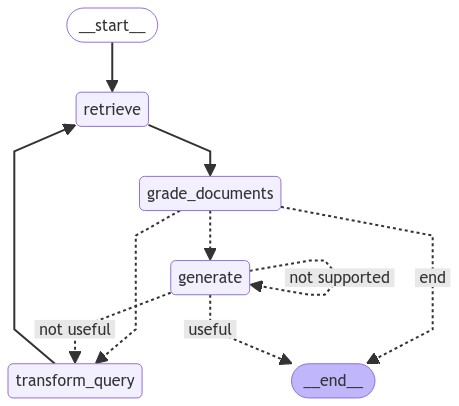

In [7]:
# Graph Workflow
display(Image(rag.workflow.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Test question
question = "What are the effects of crizotinib on lung adenocarcinoma?"

In [7]:
# Get relevant evidence
relevant_evidence = rag.get_relevant_evidence(question)


---RETRIEVE---
Question: What are the effects of crizotinib on lung adenocarcinoma?
Retrieved 5 relevant documents

---GRADE DOCUMENTS---
Document relevance: yes
Reasoning: The document provides specific data from a clinical trial that directly addresses the effects of crizotinib on lung adenocarcinoma, particularly in patients with ALK-positive lung cancer. It discusses the response rate, progression-free survival, overall survival, and quality of life improvements associated with crizotinib treatment compared to chemotherapy. This information is highly relevant to understanding the impact of crizotinib on lung adenocarcinoma.
Document relevance: no
Reasoning: The retrieved document only contains the term 'crizotinib' without any additional information or context regarding its effects on lung adenocarcinoma. It does not provide any relevant details or insights that would help answer the user's question.
Document relevance: yes
Reasoning: The document provides specific information abo

In [8]:
# Run the workflow
inputs = {"question": question, "documents": [], "generation": "", "evidence": [], "transform_count": 0}

print("\nWorkflow steps:")
for output in rag.workflow.stream(inputs):
    print("\n" + "="*50)
    for key, value in output.items():
        print(f"Step: {key}")
        if isinstance(value, dict):
            for k, v in value.items():
                if k == "documents":
                    print(f"  {k}: {len(v)} documents")
                elif k == "generation":
                    print(f"  {k}: {v[:100]}...")  # first 100 characters of generation
                else:
                    print(f"  {k}: {v}")
        else:
            print(f"  Output: {value}")
    print("="*50)


Workflow steps:

---RETRIEVE---
Question: What are the effects of crizotinib on lung adenocarcinoma?
Retrieved 5 relevant documents

Step: retrieve
  question: What are the effects of crizotinib on lung adenocarcinoma?
  generation: ...
  documents: 5 documents
  evidence: []
  transform_count: 0

---GRADE DOCUMENTS---
Document relevance: yes
Reasoning: The document provides specific data from a clinical trial that directly addresses the effects of crizotinib on lung adenocarcinoma, particularly in patients with ALK-positive lung cancer. It discusses the response rate, progression-free survival, overall survival, and quality of life improvements associated with crizotinib treatment compared to chemotherapy. This information is highly relevant to understanding the impact of crizotinib on lung adenocarcinoma.
Document relevance: no
Reasoning: The retrieved document only contains the term 'crizotinib' without any additional information or context regarding its effects on lung adenocarcin

# SDA Test

In [8]:
# Each reasoning module can be turned on/off but at least 1 must be active
sda = SelfDiscovery(
    model_type="openai", # can also be anthropic
    model_name="gpt-3.5-turbo", # can be any model from Anthropic/OpenAI API
    use_base=True,
    use_exp=False,
    use_coh=True,
    modules_path="../models/reasoning_modules"
)

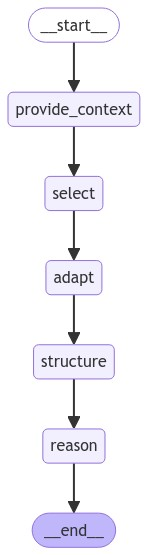

In [9]:
# Graph Workflow
display(Image(sda.graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
# Test task (simple example)
task = "Evaluate the claim: 'Regular excercise increases the risk of Lung Cancer.', state either 'True' or 'False'."

In [16]:
# Run the workflow
print("SelfDiscovery Workflow Steps:")
for step in sda.solve_stream(task):
    print("\n" + "="*50)
    for key, value in step.items():
        print(f"Step: {key}")
        if isinstance(value, dict):
            for k, v in value.items():
                if k in ["reasoning_modules", "selected_modules", "adapted_modules", "reasoning_structure", "answer"]:
                    print(f"  {k}: {v[:100]}...")  # first 100 characters
                else:
                    print(f"  {k}: {v}")
        else:
            print(f"  Output: {value}")
    print("="*50)

SelfDiscovery Workflow Steps:

Step: provide_context
  task_description: Evaluate the claim: 'Regular exercise increases the risk of Lung Cancer' based on the coherence of the supporting evidence and background knowledge. State either 'True' or 'False'.
  context: Coherence: Coherence is the extent to which a set of propositions, such as hypotheses and observations, fit together in a mutually supportive way within a given body of background knowledge (K). Coherence is enhanced when elements of a hypothesis explain and support each other, forming a consistent and unified whole.



Step: select
  selected_modules: B5. What are the key assumptions underlying this problem?
B10. Critical Thinking
B16. What is the co...

Step: adapt
  adapted_modules: B5. What are the key assumptions underlying the claim that 'Regular exercise increases the risk of L...

Step: structure
  reasoning_structure: {
    "Step 1": "Identify the key assumptions underlying the claim that 'Regular exercise increases 

In [17]:
# Final Solution
solution = sda.solve(task)
print("\nFinal Solution:")
print(json.dumps(solution, indent=2))


Final Solution:
{
  "reasoning_modules": "B1. How could I devise an experiment to help solve that problem?\nB3. How could I measure progress on this problem?\nB4. How can I simplify the problem so that it is easier to solve?\nB5. What are the key assumptions underlying this problem?\nB8. What are the long-term implications of this problem and its solutions?\nB10. Critical Thinking: This style involves analyzing the problem from different perspectives, questioning assumptions, and evaluating the evidence or information available. It focuses on logical reasoning, evidence-based decision-making, and identifying potential biases or flaws in thinking.\nB13. Use systems thinking: Consider the problem as part of a larger system and understanding the interconnectedness of various elements. Focuses on identifying the underlying causes, feedback loops, and interdependencies that influence the problem, and developing holistic solutions that address the system as a whole.\nB15. Use Reflective Thi